# 1. Данные

In [14]:
import pandas as pd

df = pd.read_csv("Amazon_Historical_StockPrice2.csv")
df.head()
print(len(df.High))

1260


# 2.Предобработка

In [15]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

нет NAN.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1260 non-null   object 
 1   Open       1260 non-null   float64
 2   High       1260 non-null   float64
 3   Low        1260 non-null   float64
 4   Close      1260 non-null   float64
 5   Adj Close  1260 non-null   float64
 6   Volume     1260 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


Не очень удобно, что Date типа object. Переделаем в datetime.

In [17]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')

In [18]:
# вычтем дни
df['Date'] = pd.to_datetime(df['Date'] - pd.to_timedelta(7, unit='d'))
df = df.groupby([pd.Grouper(key='Date', freq='W')]).mean()
df.head(10)
print(len(df.High))

261


In [19]:
import matplotlib.pyplot as plt
import numpy as np

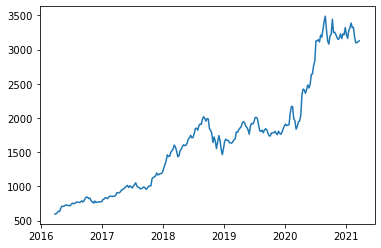

In [20]:
plt.plot(df['High'])

<AxesSubplot:xlabel='Date'>

<Figure size 1080x1440 with 0 Axes>

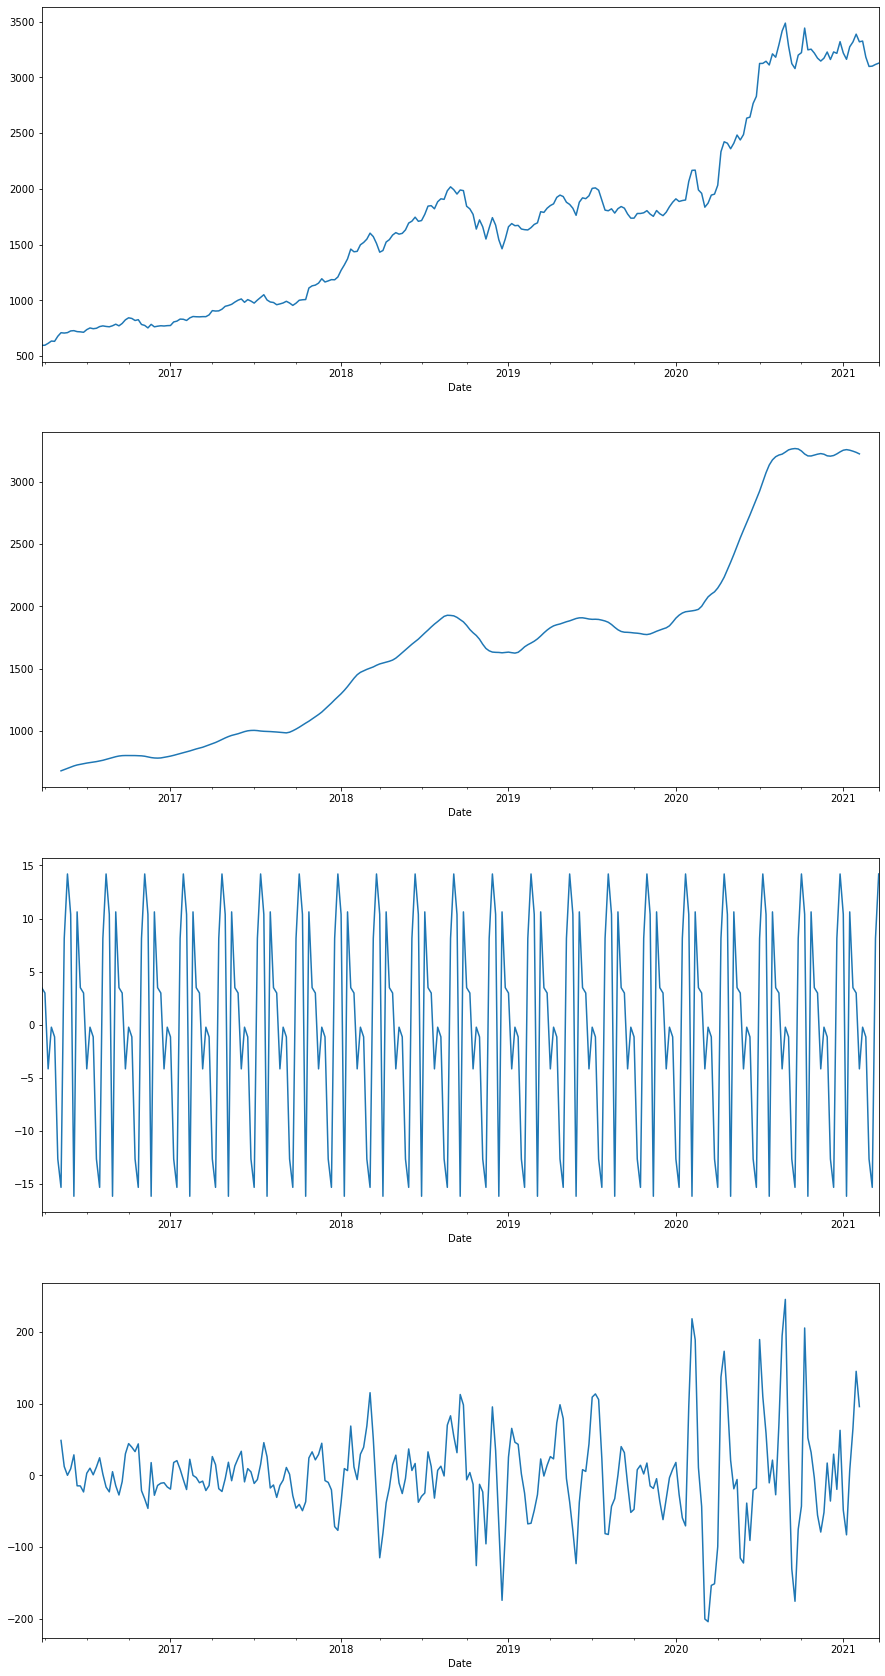

In [21]:
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(15, 20))
result = seasonal_decompose(df['High'], period=12)
# 4 строки
fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize=(15, 30))


result.observed.plot(ax=ax[0])
result.trend.plot(ax=ax[1])
result.seasonal.plot(ax=ax[2])
result.resid.plot(ax=ax[3])

Видно, что надо избавляться от тренда.

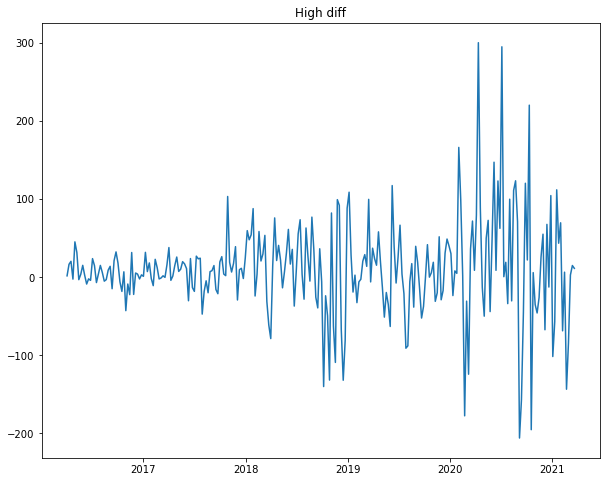

In [22]:
import matplotlib.pyplot as plt
from scipy.special import boxcox, inv_boxcox

df = df.assign(High_diff = df['High'].diff())

plt.figure(figsize = (10, 8))
plt.title('High diff')
plt.plot(df.High_diff)

In [23]:
import statsmodels.api as sm

def is_stationary(a):
    test = sm.tsa.adfuller(df[a])
    print('adf:', test[0])
    print('Critical:', test[4])
    if (test[0]>test[4]['5%']):
        print("ряд не стационарен")
    else:
        print("ряд стационарен")

In [24]:
df['High_diff'].fillna(0, inplace=True)
is_stationary('High_diff')

adf: -10.254967169390055
Critical: {'1%': -3.455952927706342, '5%': -2.8728086526320302, '10%': -2.572774990685656}
ряд стационарен


In [25]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,High_diff
Date,,,,,,,
2016-03-27,590.206018,596.723999,585.514001,592.912000,592.912000,3400760.0,0.000000
2016-04-03,594.074011,598.563989,588.276001,593.488000,593.488000,2682100.0,1.839990
2016-04-10,607.842004,615.204004,605.137988,612.112000,612.112000,3194700.0,16.640015
2016-04-17,629.591992,635.654004,621.764001,629.547998,629.547998,3741280.0,20.450000
2016-04-24,627.223987,633.291992,617.122009,622.248010,622.248010,5491280.0,-2.362012


# 3. Обучение модели

### Auto arima

In [26]:
from pmdarima.arima import auto_arima

In [27]:
size = len(df.High)
size_80 = int(size*0.8)
size_20 = int(size*0.2)


high_teach = df['High'][:size_80]
high_test = df['High'][size_80:]
high_1_teach = df['High_diff'][:size_80]
high_1_test = df['High_diff'][size_80:]

In [28]:
model = auto_arima(high_1_teach, start_p=0, start_q=0, test='adf', max_d=4, max_q=4, m=37,
           start_P=0, seasonal=True, error_action ='ignore', supress_warnings=True, trace=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[37] intercept   : AIC=2175.851, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[37] intercept   : AIC=2173.855, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[37] intercept   : AIC=2167.664, Time=0.87 sec
 ARIMA(0,0,1)(0,0,1)[37] intercept   : AIC=2163.643, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[37]             : AIC=2175.756, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[37] intercept   : AIC=2162.173, Time=0.13 sec
 ARIMA(0,0,1)(1,0,0)[37] intercept   : AIC=2163.651, Time=0.73 sec
 ARIMA(0,0,1)(1,0,1)[37] intercept   : AIC=2165.605, Time=1.51 sec
 ARIMA(1,0,1)(0,0,0)[37] intercept   : AIC=2162.695, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[37] intercept   : AIC=2161.723, Time=0.14 sec
 ARIMA(0,0,2)(1,0,0)[37] intercept   : AIC=2163.651, Time=1.15 sec
 ARIMA(0,0,2)(0,0,1)[37] intercept   : AIC=2163.652, Time=0.87 sec
 ARIMA(0,0,2)(1,0,1)[37] intercept   : AIC=2165.647, Time=1.05 sec
 ARIMA(1,0,2)(0,0,0)[37] intercept   : AIC=2162.508, Time=0.18 sec
 ARIMA(0,0,3)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  208
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -1076.862
Date:                Sun, 16 Oct 2022   AIC                           2161.723
Time:                        14:50:52   BIC                           2175.073
Sample:                    03-27-2016   HQIC                          2167.121
                         - 03-15-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.2597      3.670      1.706      0.088      -0.933      13.452
ma.L1          0.2483      0.056      4.428      0.000       0.138       0.358
ma.L2         -0.1146      0.049     -2.353      0.019      -0.210      -0.019
sigma2      1837.2740    115.032     15.972      0.000    1611.816    2062.732
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                93.94
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):              10.93   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
fitted, confint = model.predict(n_periods=size_20, return_conf_int=True)

In [30]:
inv_fitted = df['High'].shift(1)[-52:]+fitted

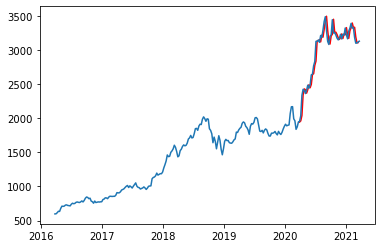

In [31]:
idx =pd.date_range(df.index[-size_20], periods=size_20, freq='W')
plt.plot(pd.Series(inv_fitted, index=idx), 'r')
plt.plot(df['High'])

### Холтер-Винтер

In [32]:
def HolterWinter_bounds(data, L, alpha, beta, gamma, m, scale):
    # находим изначальные сезонности
    season_num = int(len(data)/L)# кол-во cезонов
    seasonalities = {} # сами сезонности
    season_avgs = [] # их среднее
    # находим сезонное среднее
    season_avgs = [sum(data[L*i: L*i+L])/float(L) for i in range(season_num)]
    # находим начальные значения cезонности
    for i in range(L):
        avg_over_summ = 0.0
        for j in range(season_num):
            avg_over_summ += data[L*j+i] - season_avgs[j]
        seasonalities[i] = avg_over_summ / season_num
    # инициализируем массивы результирующих прогнозов, сгалженных, сезонных и трендовых (нужны в формулах на пред шагах)
    result = []
    smooth = []
    season = []
    trend = []
    deviation = []
    upper_bound = []
    lower_bound = []
    # пройдемся по всем данным + длинна предсказания m
    for i in range(len(data) + m):
        # инициализируем значения шага 0
        if i==0:
            smooth_val = data[0] # первое значения сглаживания
            trend_val = sum([(float(data[i+L] - data[i]) / L) for i in range(L)]) / L # первое значения тренда
            result.append(data[0]) # первая точка данных совпадает с исходной
            smooth.append(smooth_val) # добавляем первое значение сглаживание в массив трендов
            trend.append(trend_val) # добавляем первое значение тренда в массив трендов
            season.append(seasonalities[i%L]) # см mod L
            deviation.append(0)
            upper_bound.append(result[0] + scale*deviation[0])
            lower_bound.append(result[0] - scale*deviation[0])
            continue # завершаем первый шаг
        # выполняем прогноз, если вышли за пределы данных
        if i >= len(data):
            # текущее прогнозируемое значение t+1, t+2, ... (текущее m)
            curr_m = i - len(data) + 1
            result.append((smooth_val + curr_m*trend_val) + seasonalities[i%L])
            # в предсказаниях доверительный интервал будет расходиться
            deviation.append(1.01 * deviation[-1]) 
        else: # основной цикл вычисления параметров
            last_smooth_val = smooth_val
            smooth_val = alpha*(data[i] - seasonalities[i%L]) + (1 - alpha)*(smooth_val + trend_val) # обновляем lx
            trend_val = beta * (smooth_val - last_smooth_val) + trend_val*(1 - beta) # обновляем bx
            seasonalities[i%L] = gamma * (data[i] - smooth_val) + (1 - gamma)*seasonalities[i%L] # обновляем sx
            result.append(smooth_val + trend_val + seasonalities[i%L]) # записываем результат

            smooth.append(smooth_val)
            trend.append(trend_val)
            season.append(seasonalities[i%L])
            deviation.append(gamma*abs(data[i] - result[i]) + (1-gamma)*deviation[-1])
            # print(abs(data[i] - result[i])*gamma)
        # добавим доверительный интервал
        upper_bound.append(result[-1] + scale*deviation[-1]) 
        lower_bound.append(result[-1] - scale*deviation[-1])

    return result, upper_bound, lower_bound, deviation

In [33]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [34]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(w):
    # вектор ошибок
    errors = []
    values = high_1_teach
    alpha, beta, gamma = w
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам кросс-валидации, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):
        # тут preds - все сглаженное + предсказания (т.е. надо обрезать под размер теста - [-len(test):])
        preds, upper, lower, deviation = HolterWinter_bounds(data=values[train], L = 12, alpha=alpha, beta=beta, gamma=gamma, m=len(test), scale= 1.9)
        error = mean_squared_error(preds[-len(test):], values[test])
        # print(error, alpha, beta, gamma)
        errors.append(error)
    # возвращаем усреднение
    return np.mean(np.array(errors))

In [35]:
optimizer = minimize(timeseriesCVscore, x0=[0, 0, 0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
# Из оптимизатора берем оптимальное значение параметров
alpha, beta, gamma = optimizer.x
preds, upper, lower, deviation = HolterWinter_bounds(data=high_1_teach, L = 12, alpha=alpha, beta= beta, gamma=gamma, m=52, scale= 1.9)

In [36]:
inv_preds = df['High'].shift(1)[-52:] + preds[-52:]
print(preds)
len(preds)

[0.0, -0.7142019147194705, -1.1968768564270984, 0.0709631170859723, 6.789177704079632, 0.3893609681662694, -6.060825671491711, -4.084940703208394, 2.726677910278303, -3.781323668911683, -5.175033925655516, 22.722636412750912, 2.9561362782268135, -0.2996810968765737, -0.4204511372362336, 0.5924136480060705, 7.118761497245341, -1.2009220713726172, -8.335261405254832, -5.803783390695094, 0.6952705884701603, -6.5606534733884025, -7.496886812599916, 21.591184788987842, 1.309174802967073, -0.6654435987472913, -0.33425318087827915, 0.8632248184407608, 7.454875258186634, -1.8857560603137187, -9.345967263814904, -9.040906200632916, -2.556444760491763, -10.557313882588174, -10.247880555371859, 17.28735027493356, -1.8500828087172763, -4.479014727063273, -5.595866871247106, -4.871931597452609, 2.3060229222617377, -4.450544185317549, -11.764805460458703, -8.461448482412186, -1.6396746454601325, -9.10386476318427, -9.229166563663624, 19.91630018160025, 0.35136644307502696, -2.564376573029229, -3.536

260

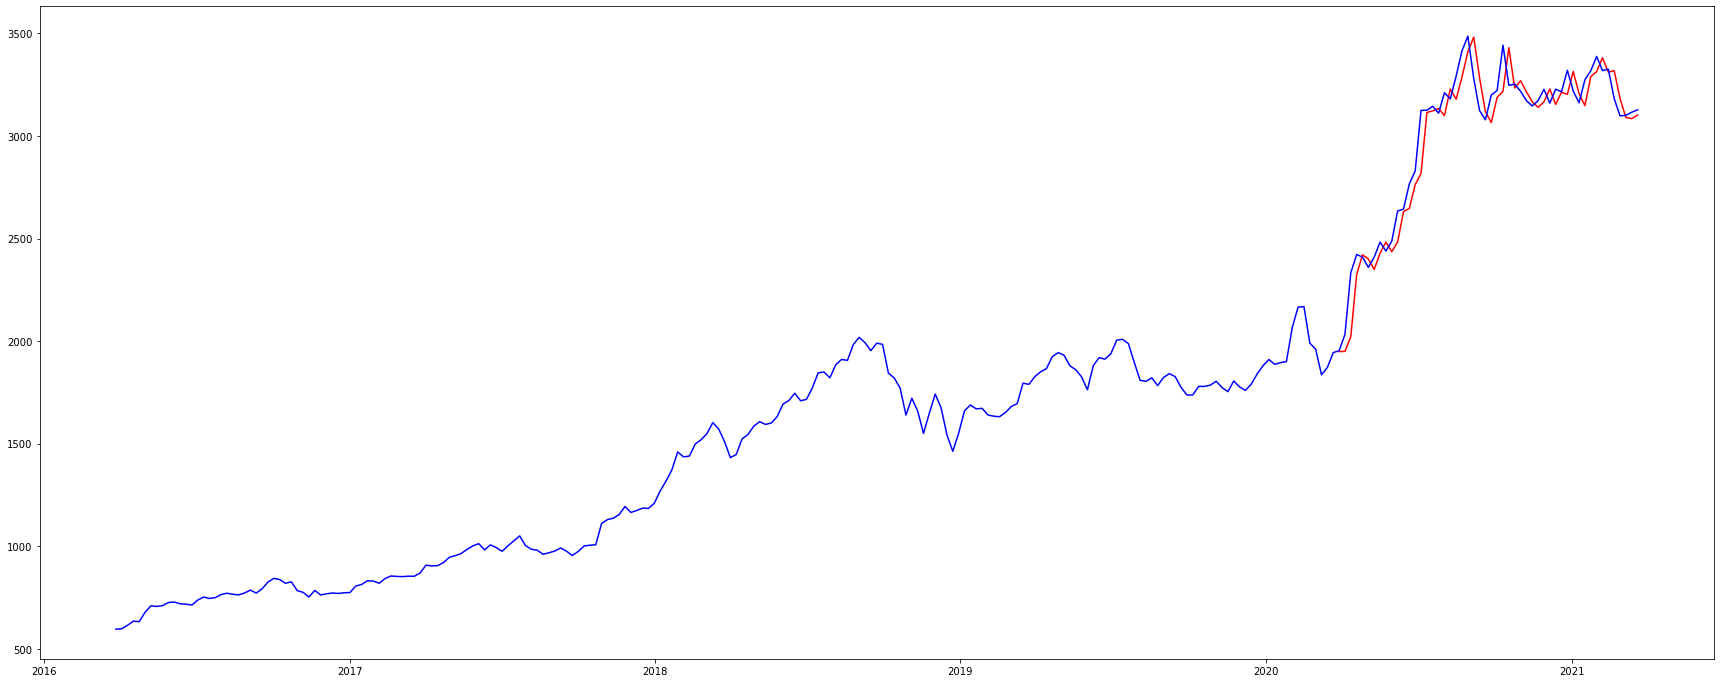

In [41]:
plt.figure(figsize=(30, 12))
idx =pd.date_range(df.index[-size_20], periods=size_20, freq='W')
plt.plot(pd.Series(inv_preds, index=idx), 'r', label = "Предсказанное")
plt.plot(df['High'], 'b', label = "Реальное")

# 4. Метрика

In [38]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(df['High'][-51:], (inv_fitted[1:])[:-1])

0.03935279775442346

In [39]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(df['High'][-52:], inv_preds)

0.026753946926290333